# Import supporting package

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import copy

import glob

import xrft
import finufft

from uncertainties import ufloat
from uncertainties import unumpy as unp
from uncertainties import umath

from datetime import datetime

import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 18

from DataContainer.ReadData import read_hdf5_file, read_hdf5_global, read_hdf5_run_time, read_csv_file
from Analyser.ImagingAnalyser import ImageAnalyser
from Analyser.FitAnalyser import FitAnalyser
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, Polylog22dModel
from Analyser.FFTAnalyser import fft, ifft, fft_nutou
from ToolFunction.ToolFunction import *

import time

from ToolFunction.HomeMadeXarrayFunction import errorbar, dataarray_plot_errorbar
xr.plot.dataarray_plot.errorbar = errorbar
xr.plot.accessor.DataArrayPlotAccessor.errorbar = dataarray_plot_errorbar

imageAnalyser = ImageAnalyser()

## Start a client for parallel computing

In [2]:
from dask.distributed import Client
client = Client(n_workers=6, threads_per_worker=4, processes=True, memory_limit='8GB')
client

<Client: 'tcp://127.0.0.1:61035' processes=6 threads=24, memory=44.70 GiB>

## Set global path for experiment

In [3]:
groupList = [
    "images/MOT_3D_Camera/in_situ_absorption",
    "images/ODT_1_Axis_Camera/in_situ_absorption",
    "images/ODT_2_Axis_Camera/in_situ_absorption",
]

dskey = {
    "images/MOT_3D_Camera/in_situ_absorption": "camera_0",
    "images/ODT_1_Axis_Camera/in_situ_absorption": "camera_1",
    "images/ODT_2_Axis_Camera/in_situ_absorption": "camera_2",
}


In [4]:
img_dir = '//DyLabNAS/Data/'
SequenceName = "Evaporative_Cooling" + "/"
folderPath = img_dir + SequenceName + '2023/04/24'# get_date()

In [5]:
shotNum = "0009"
filePath = folderPath + "/" + shotNum + "/*.h5"
filePath = folderPath + "/" + shotNum + "/2023-04-24_0009_Evaporative_Cooling_*0.h5"
print(filePath)

# # load the data from HDF5 files
# dataSetDict = {
#     dskey[groupList[i]]: read_hdf5_file(filePath, groupList[i])
#     for i in [0] # range(len(groupList))
# }

# selecte the data for centain camera
dataSet = read_hdf5_file(filePath, groupList[0])
# flip the x and y axis
dataSet = swap_xy(dataSet)

# get the scan axis name of the shot
scanAxis = get_scanAxis(dataSet)

# rechunck the data for parallel computing
dataSet = auto_rechunk(dataSet)

# calculate the absorption imaging
dataSet = imageAnalyser.get_absorption_images(dataSet)

dataSet

OD = dataSet["OD"]

OD_np = OD.to_numpy()

dataSet

//DyLabNAS/Data/Evaporative_Cooling/2023/04/24/0009/2023-04-24_0009_Evaporative_Cooling_*0.h5


<xarray.Dataset>
Dimensions:          (odt_hold_time_4: 3, runs: 3, y: 1200, x: 1920)
Coordinates:
  * odt_hold_time_4  (odt_hold_time_4) float64 0.001 0.03042 0.9252
  * runs             (runs) float64 0.0 1.0 2.0
Dimensions without coordinates: y, x
Data variables:
    atoms            (odt_hold_time_4, runs, y, x) uint16 dask.array<chunksize=(3, 3, 1200, 1920), meta=np.ndarray>
    background       (odt_hold_time_4, runs, y, x) uint16 dask.array<chunksize=(3, 3, 1200, 1920), meta=np.ndarray>
    dark             (odt_hold_time_4, runs, y, x) uint16 dask.array<chunksize=(3, 3, 1200, 1920), meta=np.ndarray>
    shotNum          (odt_hold_time_4, runs) <U2 dask.array<chunksize=(3, 3), meta=np.ndarray>
    OD               (odt_hold_time_4, runs, y, x) float64 dask.array<chunksize=(3, 3, 1200, 1920), meta=np.ndarray>
Attributes: (12/96)
    TOF_free:                          0.02
    abs_img_freq:                      110.858
    absorption_imaging_flag:           True
    backup_data:                       True
    blink_off_time:                    nan
    blink_on_time:                     nan
    ...                                ...
    z_offset:                          0.189
    z_offset_img:                      0.189
    odt_hold_time_4:                   [0.001      0.03041682 0.92518287 0.00...
    runs:                              [0. 0. 0. 1. 1. 1. 2. 2. 2.]
    scanAxis:                          ['odt_hold_time_4' 'runs']
    scanAxisLength:                    [9. 9.]

In [6]:
imageAnalyser.center = (960, 890)
imageAnalyser.span = (150, 200)
imageAnalyser.fraction = (0.1, 0.1)

dataSet_cropOD = imageAnalyser.crop_image(dataSet.OD)
dataSet_cropOD = imageAnalyser.substract_offset(dataSet_cropOD).load()
cropOD = dataSet_cropOD.to_numpy()
#dataSet_cropOD.plot.pcolormesh(cmap='jet', vmin=0, col=scanAxis[0], row=scanAxis[1])
plt.show()

## Testing with numpy

In [8]:
%matplotlib notebook

In [22]:
print('test')

test


In [18]:
plt.close()

In [25]:

fig, ax = plt.subplots(3,3)
for i in range(0,3):
    for j in range(0,3):
        ax[i][j].pcolormesh(cropOD[i][j], cmap='jet', vmin=0, vmax=2.5)
fig.show()


<IPython.core.display.Javascript object>

## Test Laserbeamsize

In [20]:
import imageio
import laserbeamsize as lbs

In [11]:
beam = cropOD[0][0]
x, y, dx, dy, phi = lbs.beam_size(beam)
print("The center of the beam ellipse is at (%.0f, %.0f)" % (x,y))
print("The ellipse diameter (closest to horizontal) is %.0f pixels" % dx)
print("The ellipse diameter (closest to   vertical) is %.0f pixels" % dy)
print("The ellipse is rotated %.0f° ccw from horizontal" % (phi*180/3.1416))

type: name 'lbs' is not defined

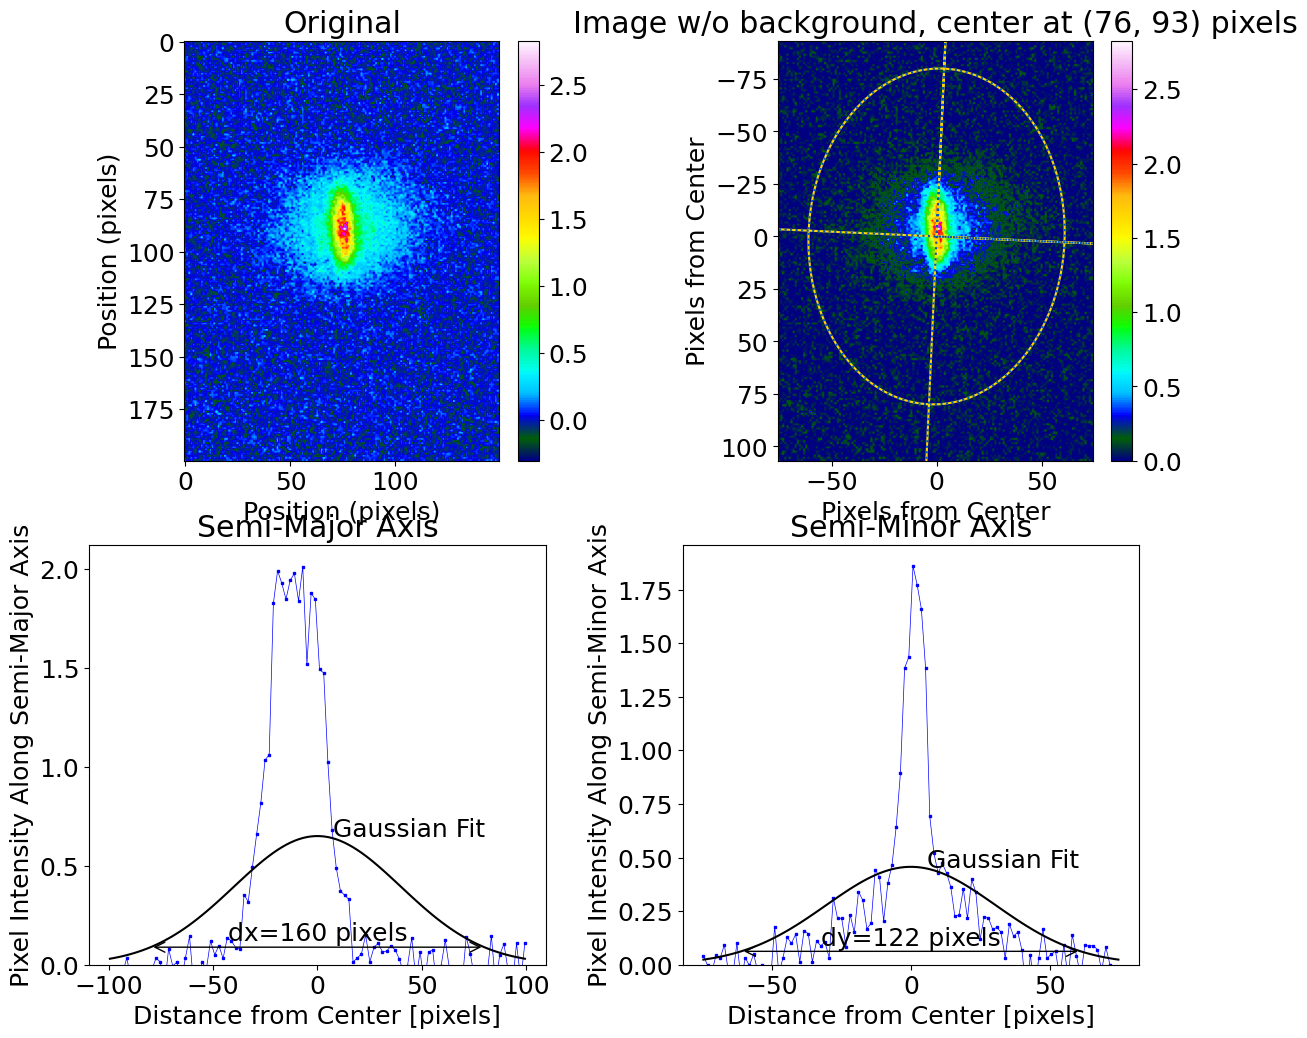

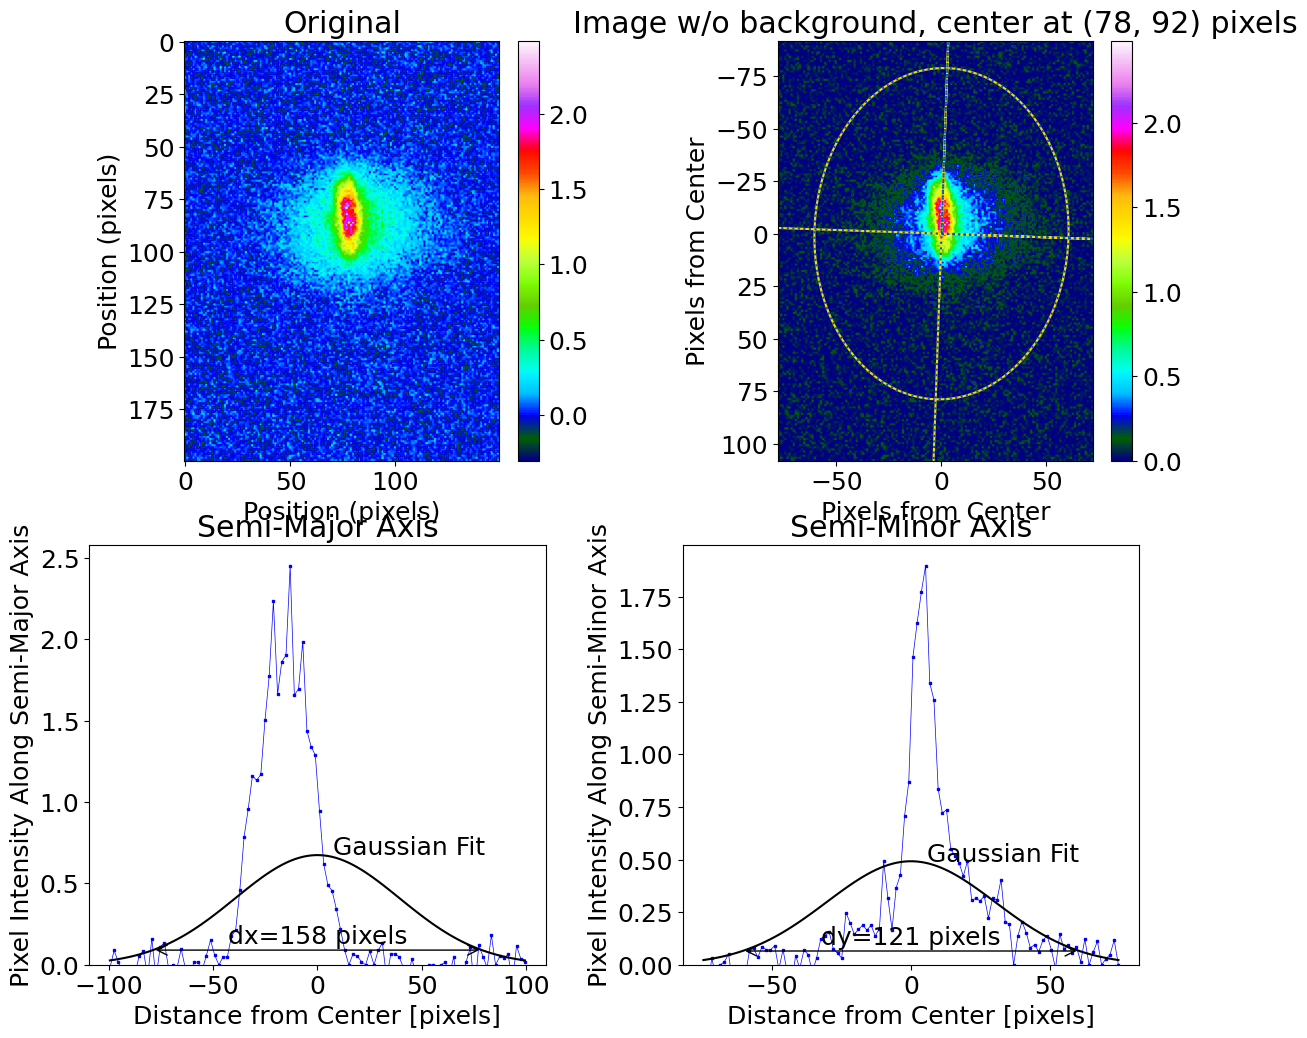

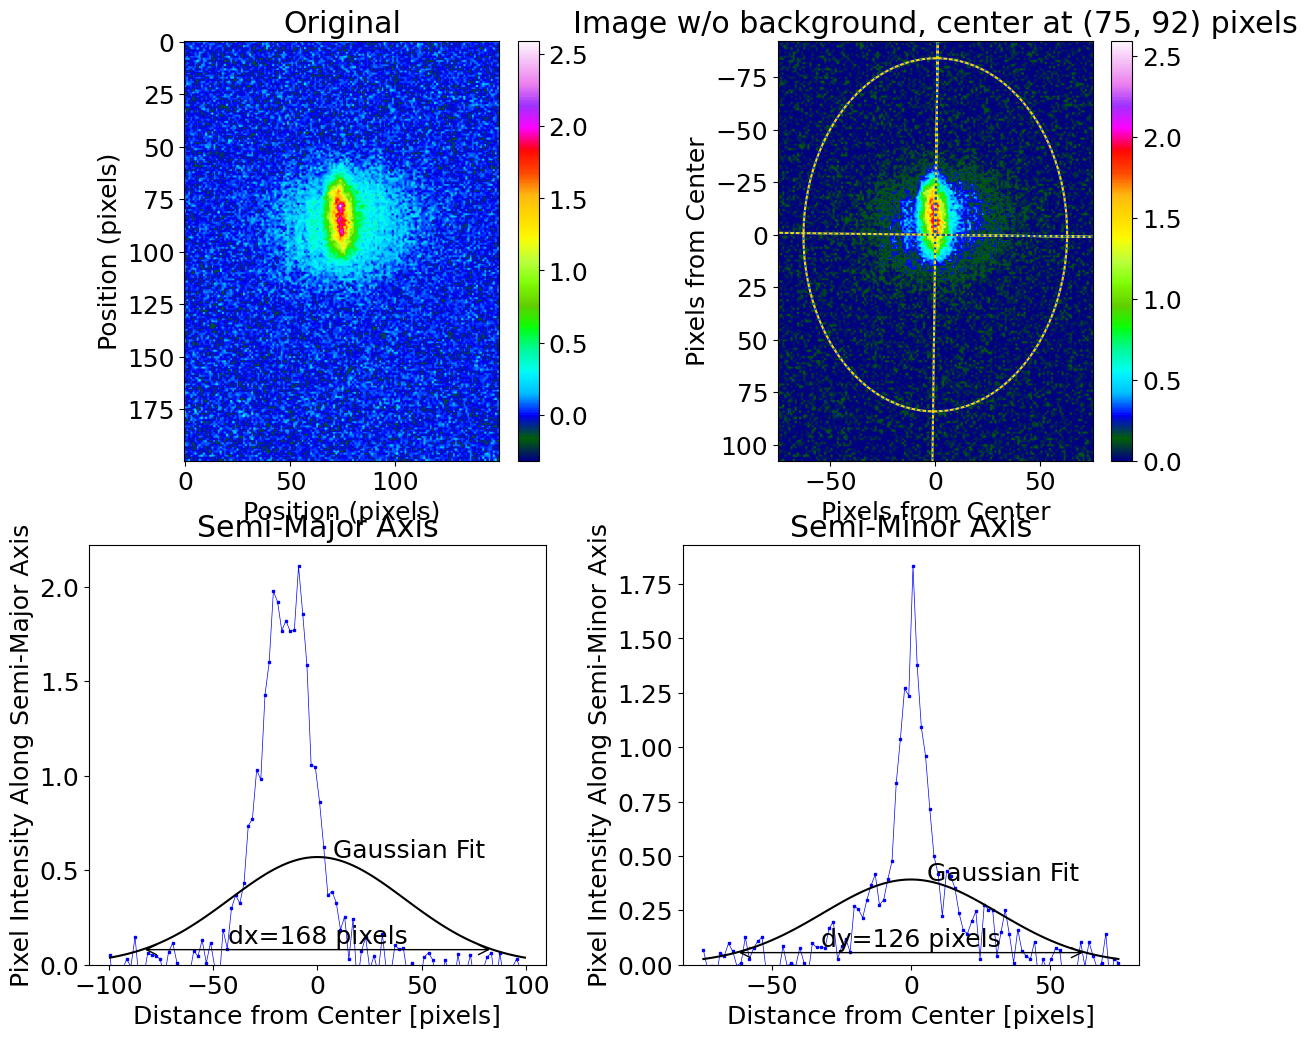

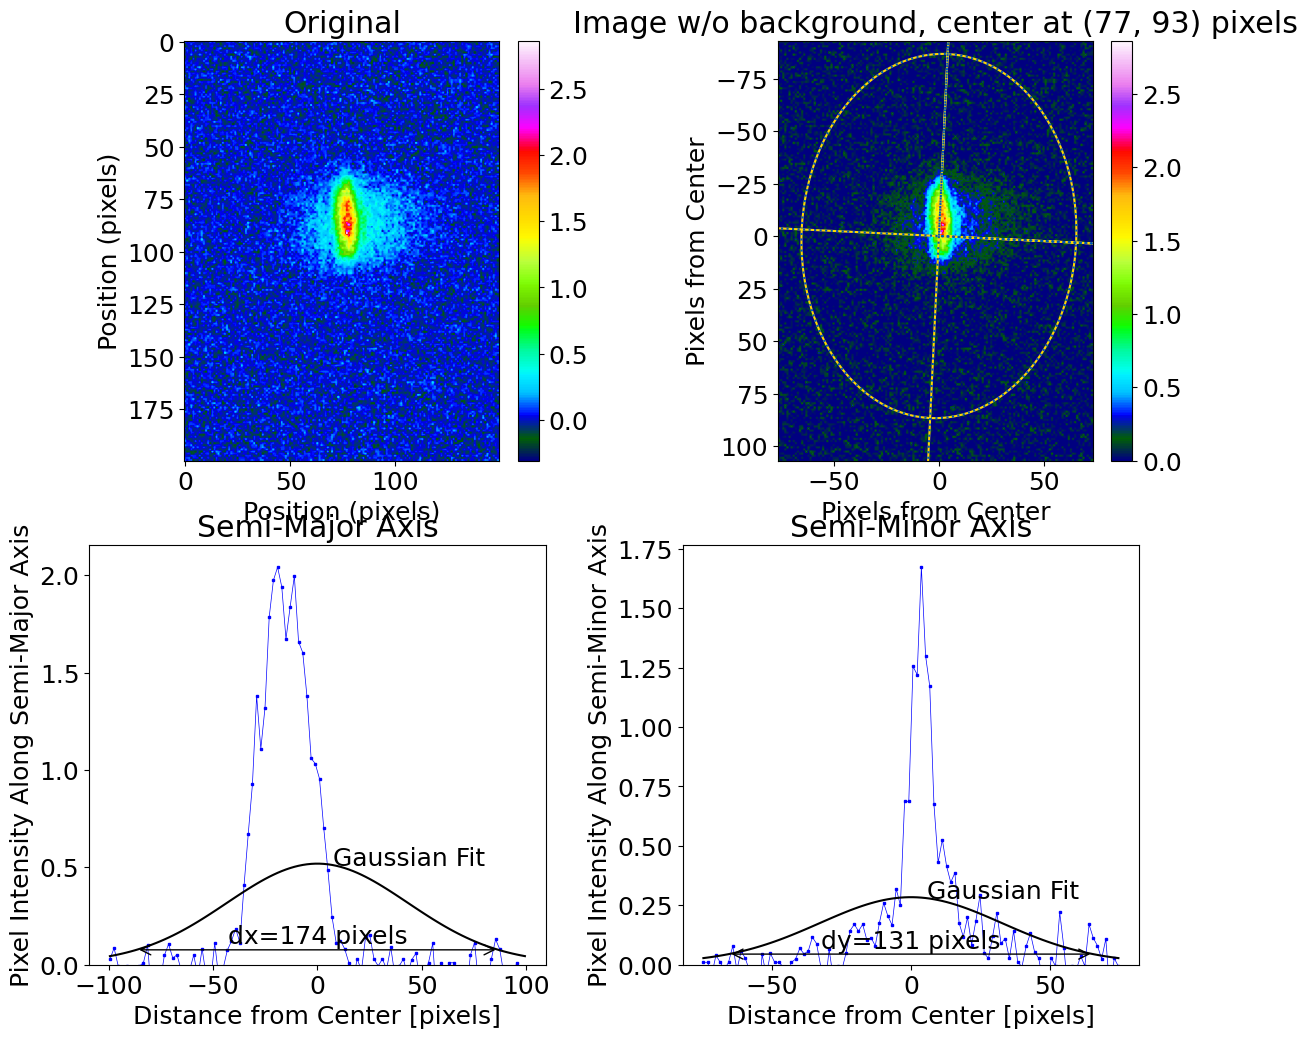

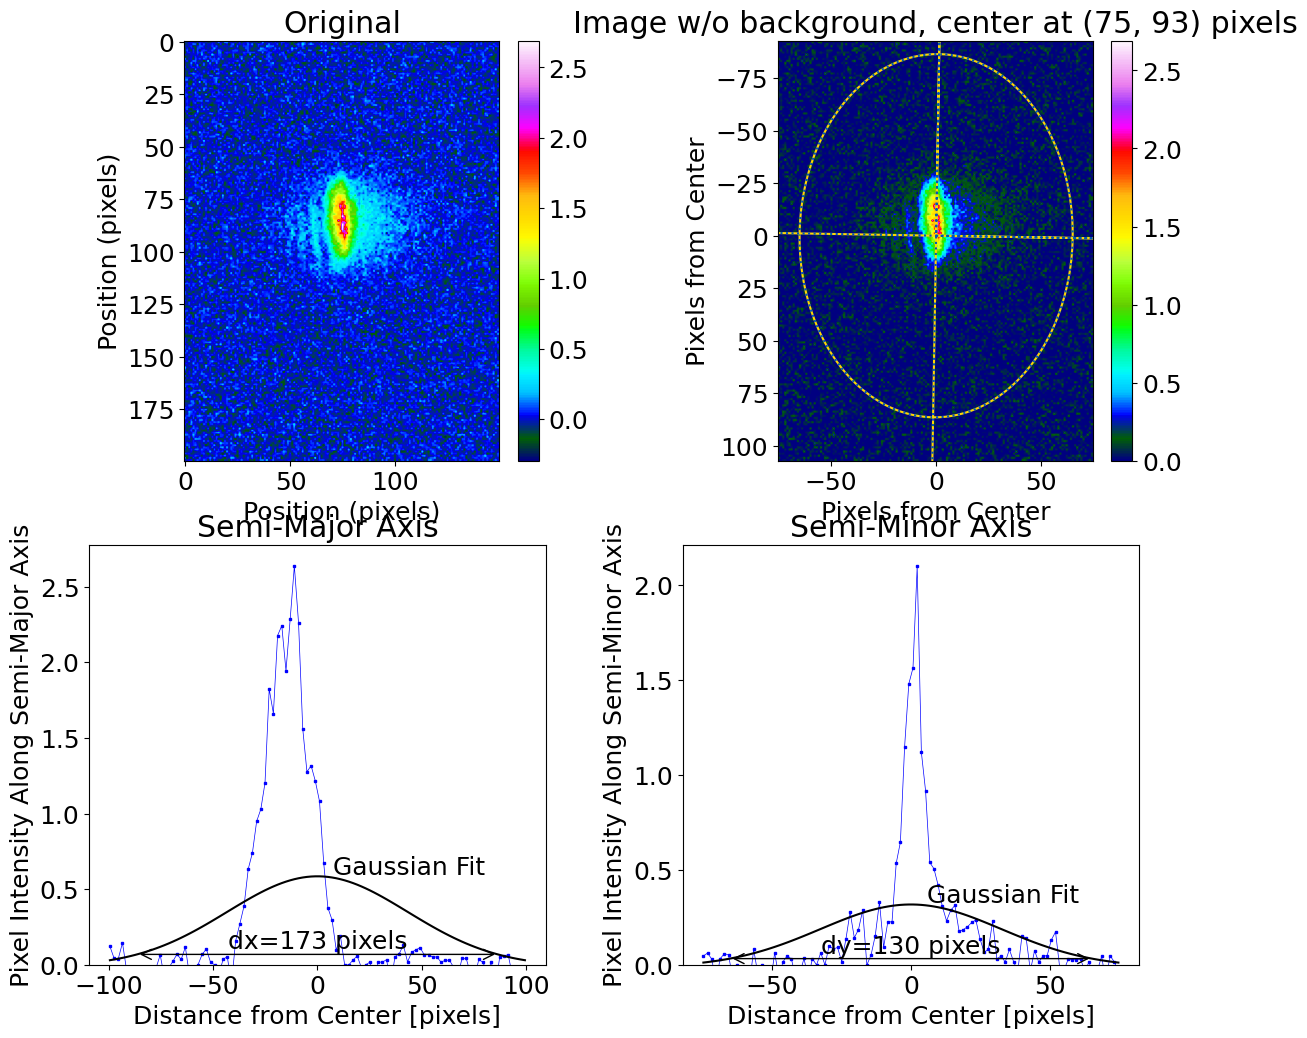

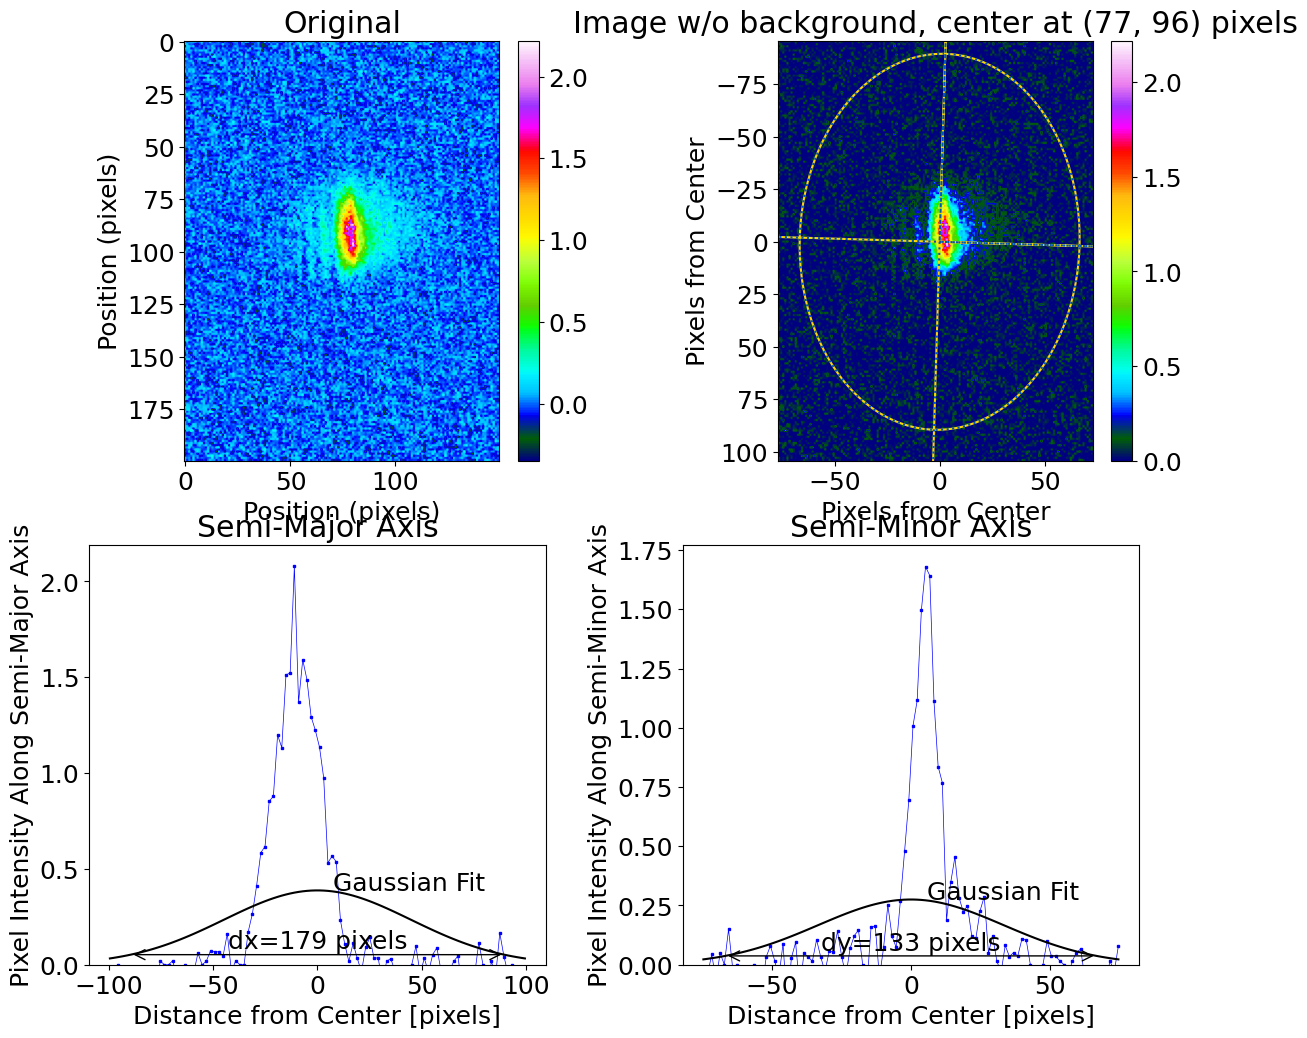

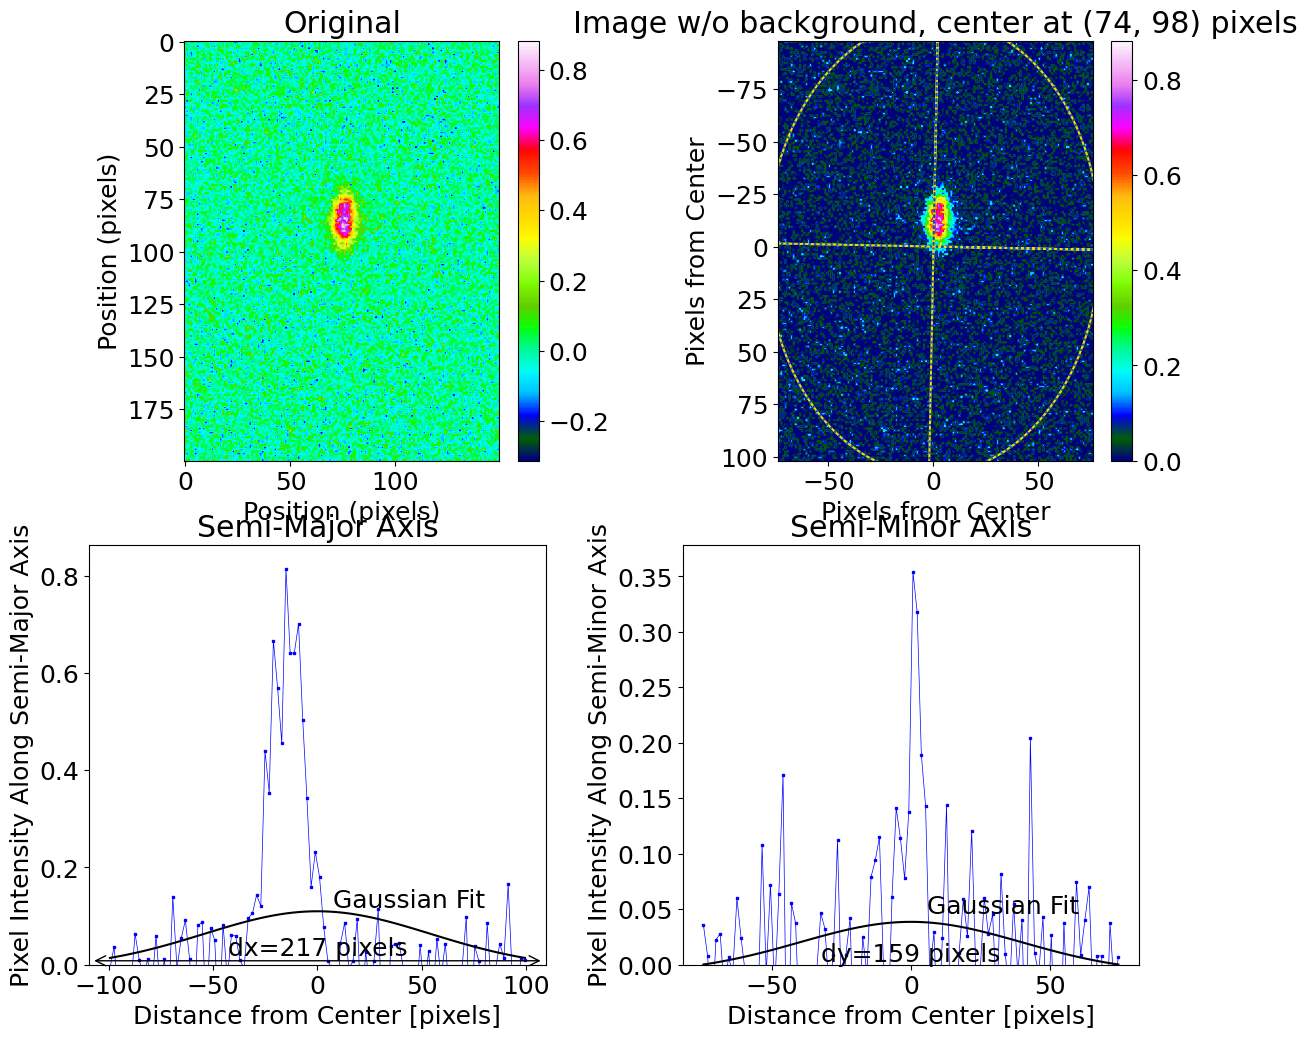

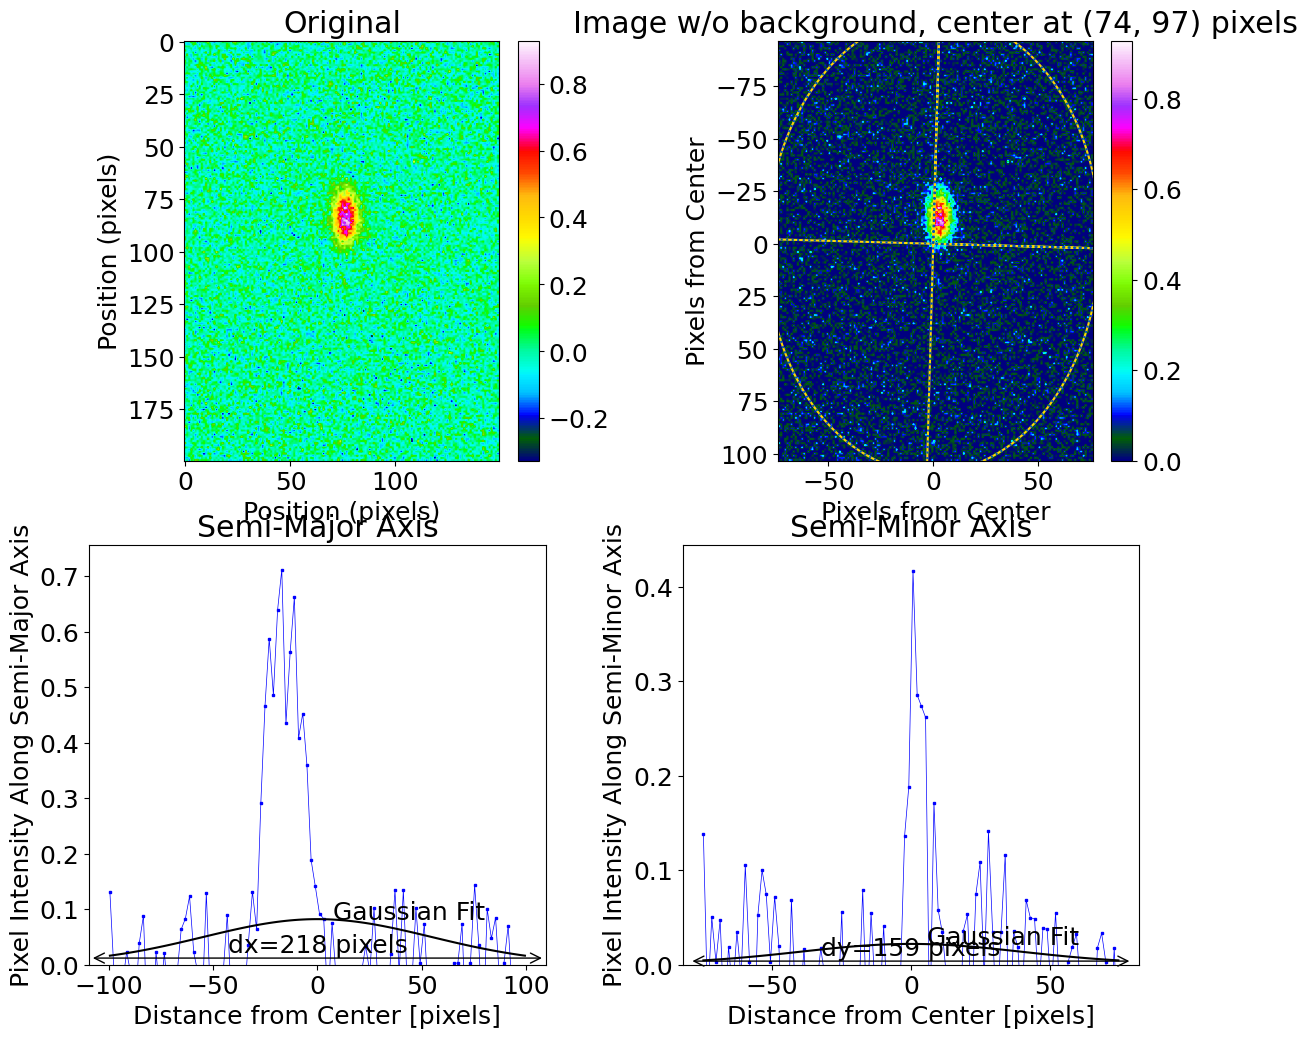

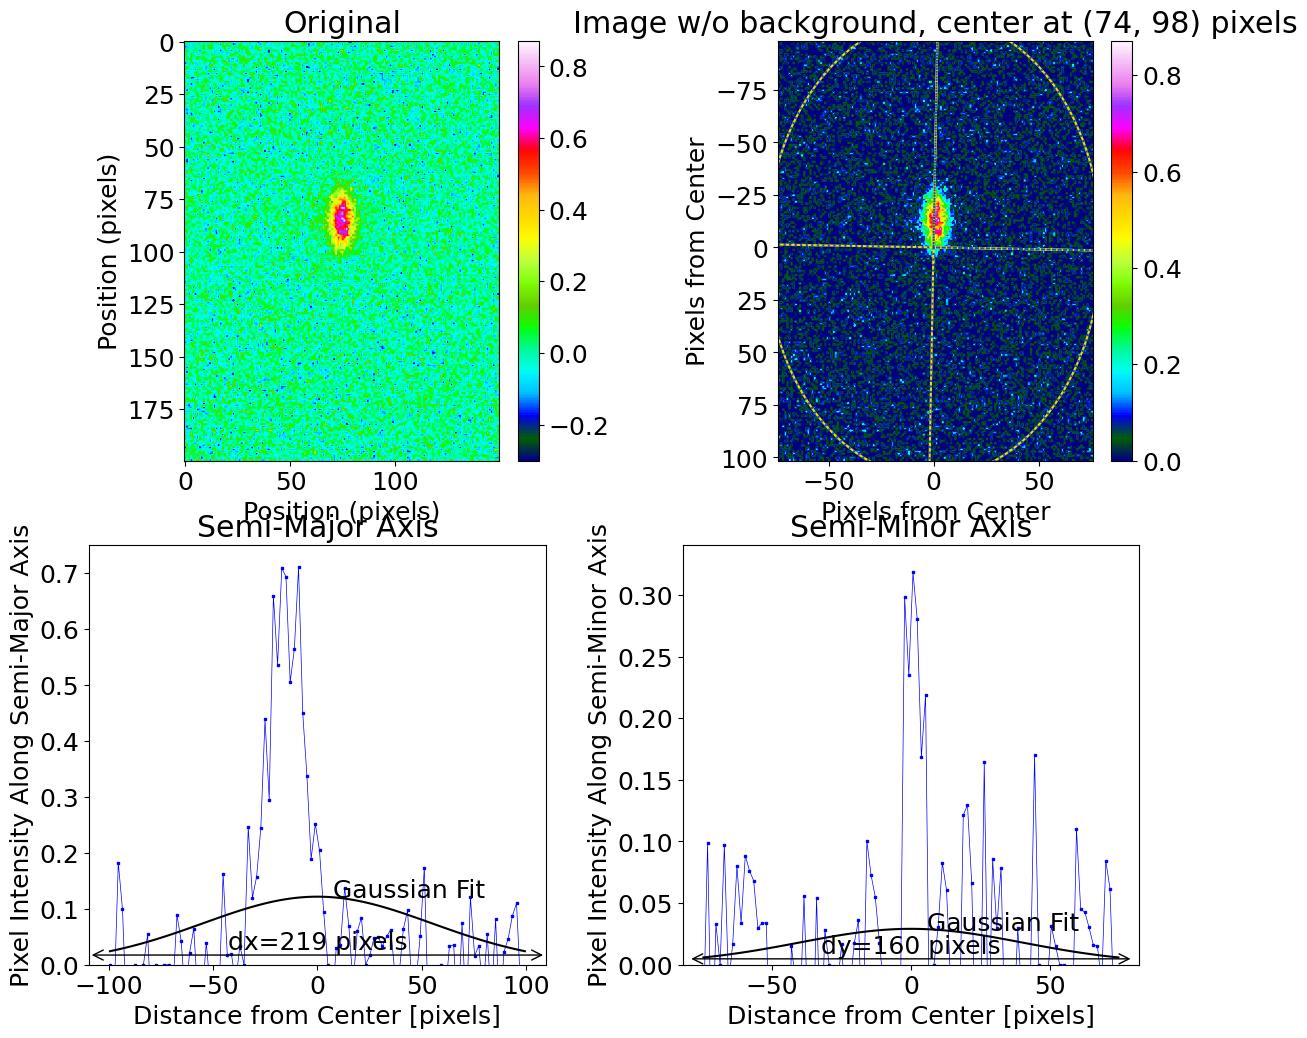

In [25]:
for i in range(0,3):
    for j in range(0,3):
        beam = cropOD[i][j]
        lbs.beam_size_plot(beam)
        plt.show()

## Try blurring image

In [7]:
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
mpl.rc('xtick', labelsize=8)
mpl.rc('ytick', labelsize=8)

In [47]:
# from opencv import moments
blurred = gaussian_filter(cropOD, sigma=1.5)

max = np.zeros((3,3,2))

for i in range(0,3):
    for j in range(0,3):
        max[i,j] = np.unravel_index(np.argmax(blurred[i,j]), blurred[0,0].shape)

thresh = gaussian_filter(cropOD, sigma=0.4)
thresh = np.where(thresh<np.max(blurred)*0.25,0,1)

#M = moments(thresh)

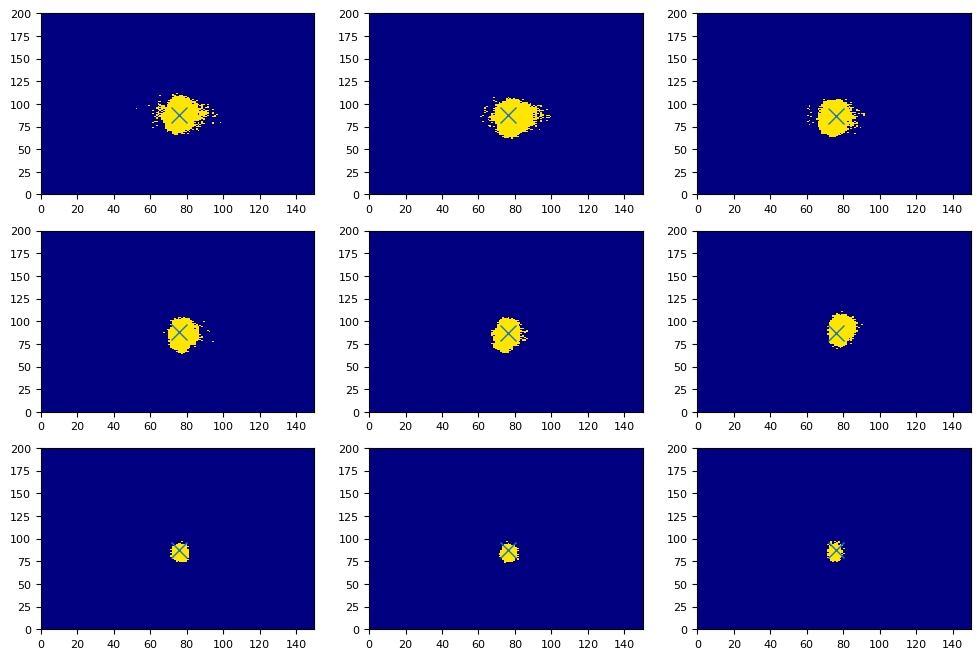

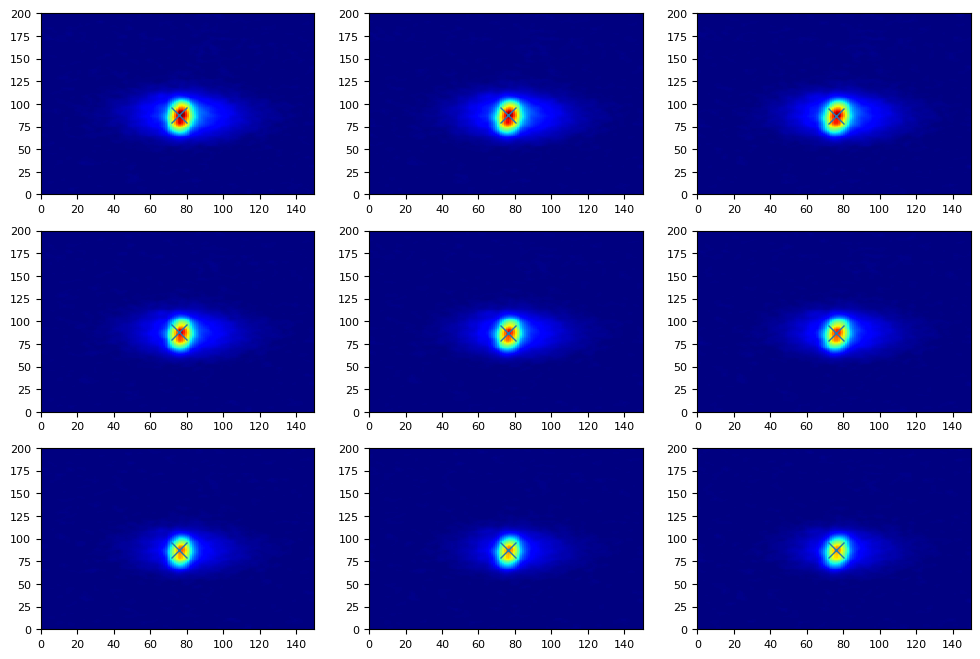

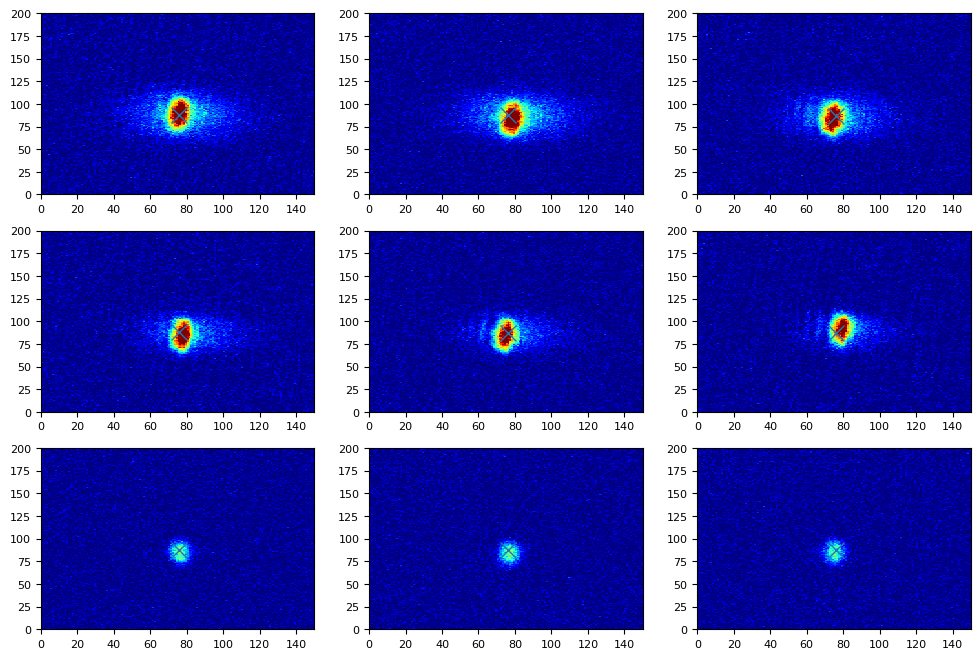

In [48]:
fsize = (12,8)

nr_plots = 3

fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)

for i in range(0,nr_plots):
    for j in range(0,nr_plots):
        # ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(max[i,j,1],max[i,j,0], marker='x', markersize=12)
plt.show()

fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
for i in range(0,nr_plots):
    for j in range(0,nr_plots):
        ax[i][j].pcolormesh(blurred[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(thresh[i][j], cmap='jet', vmin=0, vmax=1.5, alpha=1)
        #ax[i][j].pcolormesh(cropOD[i][j], cmap='hot', vmin=0, vmax=1, alpha=1)
        ax[i][j].plot(max[i,j,1],max[i,j,0], marker='x', markersize=12)
plt.show()

fig, ax = plt.subplots(nr_plots,nr_plots,figsize=fsize)
for i in range(0,nr_plots):
    for j in range(0,nr_plots):
        ax[i][j].pcolormesh(cropOD[i][j], cmap='jet', vmin=0, vmax=1.5)
        ax[i][j].plot(max[i,j,1],max[i,j,0], marker='x', markersize=12)
plt.show()

In [71]:
print('t')

## Fitting

In [19]:
data = cropOD[0,0]
data_fl = data.flatten()


In [39]:
fitModel = DensityProfileBEC2dModel()
#fitModel.set_param_hint('deltax', value=5)

params = fitModel.make_params(BEC_amplitude=dict(value=np.max(data),max=np.max(data)))
params.add_many(
    ('thermal_amplitude',1,True,0)
)
params

type: name 'data' is not defined

In [119]:
params.update({'BEC_amplitude',5})

type: '{5, 'BEC_amplitude'}' is not a Parameters object

In [34]:
print(polylog2_2d(x))

type: name 'polylog' is not defined

## Function testing

In [45]:
## How fast are the functions

print(np.shape(data))
x = np.linspace(0,150, 151)
y = np.linspace(0,200, 201)

X, Y = np.meshgrid(x,y)
x_fl = x_.flatten()
y_fl = y_.flatten()


plt.pcolormesh(density_profile_BEC_2d(x=X, y=Y))
plt.show()

type: name 'data' is not defined

In [10]:
import matplotlib as mpl


In [46]:
from Analyser.FitAnalyser import density_profile_BEC_2d,polylog2_2d, ThomasFermi_2d


x = np.linspace(-5,5,1000)

th_amp = 5
bec_amp = 1
plt.close()
plt.plot(x, density_profile_BEC_2d(x, BEC_amplitude=bec_amp, thermal_amplitude=th_amp))
plt.plot(x, polylog2_2d(x, amplitude=th_amp), linestyle='dotted')
plt.plot(x, ThomasFermi_2d(x,amplitude=bec_amp),  linestyle='dotted')
plt.show()


<IPython.core.display.Javascript object>

In [33]:
plt.plot(1,2)
plt.show()

In [1]:
def find_fwhm(f_x, x):
    ind = 0
    for i in range(0, len(f_x)):
        if f_x[i] > np.max(f_x)/2 and ind ==0:
            a = i
            ind = 1

        if f_x[i] < np.max(f_x)/2 and ind ==1:
            b = i
            break
    return x[b] - x[a]

In [22]:
x = np.linspace(-3,3,100000)
fac = find_fwhm(ThomasFermi_2d(x, sigmax=1), x)
print(fac)
find_fwhm(ThomasFermi_2d(x, sigmax=0.5), x)

type: name 'find_fwhm' is not defined

In [38]:
fac * 0.5

0.6082860828608285

In [38]:
def polylog(power, numerator, order=20):
    dataShape = numerator.shape
    numerator = np.tile(numerator, (order, 1))
    numerator = np.power(numerator.T, np.arange(1, order + 1)).T

    denominator = np.arange(1, order + 1)
    denominator = np.tile(denominator, (dataShape[0], 1))
    denominator = denominator.T

    data = numerator / np.power(denominator, power)

    return np.sum(data, axis=0)

def polylog2_2d(x, y=0.0, centerx=0.0, centery=0.0, amplitude=1.0, sigmax=1.0, sigmay=1.0, order=20):
    ## Approximation of the polylog function with 2D gaussian as argument. -> discribes the thermal part of the cloud
    return amplitude / 2 / np.pi / 1.20206 / max(tiny, sigmax * sigmay) * polylog(2, np.exp( -((x-centerx)**2/(2 * (sigmax)**2))-((y-centery)**2/( 2 * (sigmay)**2)) ),order=order)

In [22]:
import timeit

a = time.time()
polylog2_2d(x, order=2000)
b= time.time()

print((b-a)*1e3)


In [36]:
x = np.linspace(0,1,151)
max_prec = polylog2_2d(x,order=3000)

type: polylog2_2d() got an unexpected keyword argument 'order'

In [35]:
#print(polylog2_2d(x,order=2))

print(polylog2_2d(x,order=6)/max_prec)

type: polylog2_2d() got an unexpected keyword argument 'order'

In [69]:
print(max_prec)

[0.21774815 0.21772299 0.21764863 0.21752807 0.21736539 0.21716479
 0.21693003 0.21666411 0.21636937 0.21604763 0.21570038 0.21532891
 0.21493435 0.21451771 0.21407994 0.21362191 0.21314442 0.21264822
 0.21213403 0.21160251 0.21105429 0.21048997 0.20991011 0.20931524
 0.2087059  0.20808256 0.2074457  0.20679578 0.20613322 0.20545843
 0.20477184 0.20407381 0.20336473 0.20264496 0.20191484 0.20117472
 0.20042492 0.19966577 0.19889756 0.19812059 0.19733517 0.19654157
 0.19574007 0.19493093 0.19411441 0.19329077 0.19246026 0.19162311
 0.19077957 0.18992985 0.18907419 0.18821281 0.18734591 0.18647371
 0.1855964  0.1847142  0.18382729 0.18293586 0.18204011 0.18114021
 0.18023634 0.17932869 0.17841741 0.17750267 0.17658465 0.1756635
 0.17473938 0.17381245 0.17288285 0.17195074 0.17101626 0.17007955
 0.16914075 0.16820001 0.16725745 0.16631321 0.16536742 0.16442021
 0.16347169 0.162522   0.16157125 0.16061957 0.15966706 0.15871384
 0.15776002 0.15680572 0.15585103 0.15489607 0.15394094 0.15298

## Fitting Code Jianshun

In [40]:
from Analyser.FitAnalyser import ThomasFermi2dModel, DensityProfileBEC2dModel, polylog2_2d

fitModel = DensityProfileBEC2dModel()
# fitModel = ThomasFermi2dModel()

fitAnalyser = FitAnalyser(fitModel, fitDim=2)

# fitAnalyser = FitAnalyser("Gaussian-2D", fitDim=2)

# dataSet_cropOD = dataSet_cropOD.chunk((1,1,100,100))

start = time.time()
params = fitAnalyser.guess(dataSet_cropOD, guess_kwargs=dict(pureBECThreshold=0.3), dask="parallelized")

time_guess = time.time()
fitResult = fitAnalyser.fit(dataSet_cropOD, params).load()
end = time.time()

print(f"time guess ={time_guess-start} \n time fit = {end-time_guess}")

time guess =5.85423469543457 
 time fit = 1.361077070236206


In [42]:
fitResult

<xarray.DataArray 'OD' (odt_hold_time_4: 3, runs: 3)>
array([[<lmfit.model.ModelResult object at 0x00000177FBA9D280>,
        <lmfit.model.ModelResult object at 0x00000177FBAAB5E0>,
        <lmfit.model.ModelResult object at 0x00000177F9603B50>],
       [<lmfit.model.ModelResult object at 0x00000177FBAA2BB0>,
        <lmfit.model.ModelResult object at 0x00000177F97F4160>,
        <lmfit.model.ModelResult object at 0x00000177FBA9BFD0>],
       [<lmfit.model.ModelResult object at 0x00000177F981FCD0>,
        <lmfit.model.ModelResult object at 0x00000177F981FC70>,
        <lmfit.model.ModelResult object at 0x00000177F9837730>]],
      dtype=object)
Coordinates:
  * odt_hold_time_4  (odt_hold_time_4) float64 0.001 0.03042 0.9252
  * runs             (runs) float64 0.0 1.0 2.0
Attributes:
    IMAGE_SUBCLASS:       IMAGE_GRAYSCALE
    IMAGE_VERSION:        1.2
    IMAGE_WHITE_IS_ZERO:  0
    x_start:              885
    x_end:                1035
    y_end:                990
    y_start:              790
    x_center:             960
    y_center:             890
    x_span:               150
    y_span:               200

In [49]:
a = fitResult[0][0]
params = {'BEC_centerx', 'BEC_centery'}
fitAnalyser.get_fit_full_result(a)


<xarray.Dataset>
Dimensions:              ()
Coordinates:
    odt_hold_time_4      float64 0.001
    runs                 float64 0.0
Data variables: (12/13)
    BEC_amplitude        object 108.97389973368065+/-nan
    thermal_amplitude    object 1679.5248259002558+/-nan
    BEC_centerx          object 76.78893406629503+/-nan
    BEC_centery          object 88.87734904054957+/-nan
    thermal_centerx      object 78.76046091342899+/-nan
    thermal_centery      object 86.70094810836741+/-nan
    ...                   ...
    BEC_sigmay           object 5.27118321157311+/-nan
    thermal_sigmax       object 24.551284336095115+/-nan
    thermal_sigmay       object 19.687679247584988+/-nan
    deltax               object 73.50926746007993+/-nan
    thermalAspectRatio   object 0.8019001767105238+/-nan
    condensate_fraction  object 0.060930375947041655+/-nan
Attributes:
    IMAGE_SUBCLASS:       IMAGE_GRAYSCALE
    IMAGE_VERSION:        1.2
    IMAGE_WHITE_IS_ZERO:  0
    x_start:              885
    x_end:                1035
    y_end:                990
    y_start:              790
    x_center:             960
    y_center:             890
    x_span:               150
    y_span:               200

In [118]:
fitResult['odt_hold_time_4']

<xarray.DataArray 'odt_hold_time_4' (odt_hold_time_4: 3)>
array([0.001   , 0.030417, 0.925183])
Coordinates:
  * odt_hold_time_4  (odt_hold_time_4) float64 0.001 0.03042 0.9252

In [8]:
def polylog(power, numerator,order):

    dataShape = numerator.shape
    numerator = np.tile(numerator, (order, 1))
    numerator = np.power(numerator.T, np.arange(1, order+1)).T

    denominator = np.arange(1, order+1)
    denominator = np.tile(denominator, (dataShape[0], 1))
    denominator = denominator.T

    data = numerator/ np.power(denominator, power)

    return np.sum(data, axis=0)